<a href="https://colab.research.google.com/github/monosij777/An-Ensemble-GAN-Enhanced-Modulated-Deep-Learning-Model-for-Intelligent-Pancreatic-Tumor-Detection/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data loading

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Paths to your image and mask datasets
image_dir = "/content/drive/MyDrive/archive/Dataset/Dataset/X_train"
mask_dir = "/content/drive/MyDrive/archive/Mask/Mask/Y_train_Cancer"

# Get the list of all image and mask files
images = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
masks = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

image_subset = images[:5000]
mask_subset = masks[:5000]

# Train-validation split (80% train, 20% validation)
train_images, val_images, train_masks, val_masks = train_test_split(
    image_subset, mask_subset, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")


Training set size: 4000
Validation set size: 1000


In [ ]:
import tensorflow as tf

# Constants
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

# Function to load and preprocess a single image or mask
def load_and_preprocess_image(file_path, is_mask=False):
    # Read and decode the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=1 if is_mask else 3)  # Grayscale for masks, RGB for images

    # Resize the image
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

    # Normalize the pixel values
    img = img / 255.0

    return img

# Function to create a TensorFlow dataset
def create_dataset(image_paths, mask_paths, batch_size):
    # Create TensorFlow datasets for images and masks
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    mask_dataset = tf.data.Dataset.from_tensor_slices(mask_paths)

    # Preprocess images and masks
    image_dataset = image_dataset.map(lambda x: load_and_preprocess_image(x, is_mask=False), num_parallel_calls=AUTO)
    mask_dataset = mask_dataset.map(lambda x: load_and_preprocess_image(x, is_mask=True), num_parallel_calls=AUTO)

    # Combine image and mask datasets
    dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))

    # Shuffle, batch, and prefetch
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTO)

    return dataset

# Create datasets
train_dataset = create_dataset(train_images, train_masks, BATCH_SIZE)
val_dataset = create_dataset(val_images, val_masks, BATCH_SIZE)

# Verify the data pipeline
for images, masks in train_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")


Image batch shape: (32, 128, 128, 3)
Mask batch shape: (32, 128, 128, 1)


# Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Constants
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3  # For RGB images
DROPOUT_RATE = 0.2
REGULARIZER = tf.keras.regularizers.l2(0.001)

# Function to create U-Net
def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Dropout(DROPOUT_RATE)(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Dropout(DROPOUT_RATE)(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b1 = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(p2)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Dropout(DROPOUT_RATE)(b1)
    b1 = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(b1)
    b1 = layers.BatchNormalization()(b1)

    # Decoder
    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(b1)
    u2 = layers.concatenate([u2, c2])
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(u2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Dropout(DROPOUT_RATE)(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)

    u3 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u3 = layers.concatenate([u3, c1])
    c4 = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(u3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Dropout(DROPOUT_RATE)(c4)
    c4 = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Build and compile the model
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = build_unet(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 32)   │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 32)   │            128 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 64, 64, 32)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 64)     │            256 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 64)     │            256 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 32, 32, 64)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 128)    │            512 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout) 

 Total params: 469,089 (1.79 MB)

 Trainable params: 467,809 (1.78 MB)

 Non-trainable params: 1,280 (5.00 KB)

# Model Training

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.5212 - loss: 1.2923 - val_accuracy: 0.9488 - val_loss: 1.0380
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.7260 - loss: 0.9807 - val_accuracy: 0.9965 - val_loss: 0.8474
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.9218 - loss: 0.8005 - val_accuracy: 0.9965 - val_loss: 0.6849
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.9881 - loss: 0.6695 - val_accuracy: 0.9965 - val_loss: 0.5695
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.9964 - loss: 0.5680 - val_accuracy: 0.9965 - val_loss: 0.4833
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.9967 - loss: 0.4855 - val_accuracy: 0.9965 - val_loss: 0.4121
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.9966 - loss: 0.4163 - val_accuracy: 0.9965 - val_loss: 0.3518
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.9967 - loss: 0.357

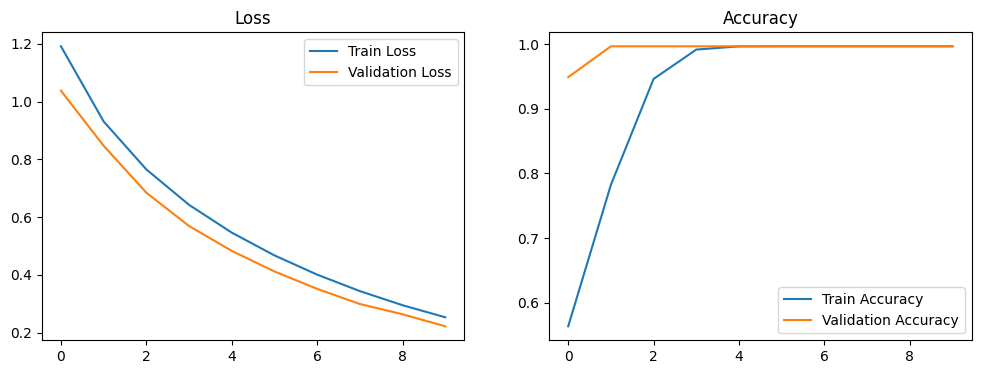

In [ ]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # Adjust based on your dataset and computational limits
    callbacks=early_stopping
)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()


# GAN training

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

# Generator Model
def build_generator(latent_dim):
    model = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, activation="relu", input_dim=latent_dim),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding="same", activation="tanh")
    ])
    return model

# Discriminator Model
def build_discriminator(input_shape=(128, 128, 3)):
    model = tf.keras.Sequential([
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding="same", input_shape=input_shape),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    return model


In [ ]:
# Hyperparameters
LATENT_DIM = 100
BATCH_SIZE = 32
EPOCHS = 10000
SAVE_INTERVAL = 100

# Build Generator and Discriminator
generator = build_generator(LATENT_DIM)
discriminator = build_discriminator()
discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002, beta_1=0.5),
                      loss="binary_crossentropy",
                      metrics=["accuracy"])

# Combined GAN Model
discriminator.trainable = False  # Freeze discriminator weights when training generator
gan_input = layers.Input(shape=(LATENT_DIM,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002, beta_1=0.5), loss="binary_crossentropy")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "functional_4" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(None, 64, 64, 3)[0m

Arguments received by Sequential.call():
  • args=('<KerasTensor shape=(None, 64, 64, 3), dtype=float32, sparse=False, name=keras_tensor_82>',)
  • kwargs={'mask': 'None'}

In [ ]:
# Load and preprocess training data
def preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (128, 128))
    img = (img / 127.5) - 1  # Normalize to [-1, 1]
    return img

train_images = [preprocess_image(img_path) for img_path in train_images]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE).shuffle(1000)

# Save generated images
def save_generated_images(epoch, generator, latent_dim, save_dir="generated_images"):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    noise = np.random.normal(0, 1, (16, latent_dim))  # Generate 16 random samples
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]

    plt.figure(figsize=(4, 4))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i])
        plt.axis("off")
    plt.savefig(f"{save_dir}/epoch_{epoch}.png")
    plt.close()

# Training Loop
def train_dcgan(generator, discriminator, gan, dataset, epochs, latent_dim, save_interval):
    for epoch in range(epochs):
        for real_images in dataset:
            # Train discriminator
            batch_size = real_images.shape[0]
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            fake_images = generator.predict(noise)

            real_labels = np.ones((batch_size, 1)) * 0.9  # Label smoothing
            fake_labels = np.zeros((batch_size, 1))

            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            valid_labels = np.ones((batch_size, 1))
            g_loss = gan.train_on_batch(noise, valid_labels)

        # Print losses
        print(f"{epoch + 1}/{epochs} [D loss: {d_loss[0]:.4f}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

        # Save generated images at intervals
        if (epoch + 1) % save_interval == 0:
            save_generated_images(epoch + 1, generator, latent_dim)

# Train the DCGAN
train_dcgan(generator, discriminator, gan, train_dataset, EPOCHS, LATENT_DIM, SAVE_INTERVAL)


NameError: name 'generator' is not defined